---

# Predicting Credit Card Default

### Best Model Analysis

---

# Loading  preprocessed data

Note: 
Open <a href="./data_preparation.ipynb">data_preparation.ipynb</a> to see how the data was preprocessed. 

In [1]:
import pandas as pd
import numpy as np
import imblearn #libary for imbalanced functions i.e. K-means SMOTE
from sklearn import preprocessing

#from google.colab import drive
#drive.mount('/content/drive')
# filename = "drive/Shareddrives/DS-project/default_processed.csv"

filename = "default_processed.csv"
data = pd.read_csv(filename)
data.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000.0,2.0,2.0,1.0,24,2,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,2.0,2.0,2.0,26,-1,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,90000.0,2.0,2.0,2.0,34,0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,50000.0,2.0,2.0,1.0,37,0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,50000.0,1.0,2.0,1.0,57,-1,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0
5,50000.0,1.0,1.0,2.0,37,0,0.0,0.0,0.0,0.0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0.0
6,500000.0,1.0,1.0,2.0,29,0,0.0,0.0,0.0,0.0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0.0
7,100000.0,2.0,2.0,2.0,23,0,-1.0,-1.0,0.0,0.0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0.0
8,140000.0,2.0,3.0,1.0,28,0,0.0,2.0,0.0,0.0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0.0
9,20000.0,1.0,3.0,2.0,35,-2,-2.0,-2.0,-2.0,-1.0,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0.0


# Validation Set Partitioning

### K-fold Cross Validation 

In order to ascertain a standard deviation and investigate the optimal hyperparameters for each model, we will employ stratified k-fold cross-validation. This algorithm will split our dataset into k consecutive folds in a startefied manner such that it preserves the same target class distribution.

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

features = data.iloc[:, :-1] #acquire all rows, and all columns except for last one (label)
label = data.iloc[:,[-1]] #assignt to frame with all rows and the last column (label)

label = preprocessing.LabelEncoder().fit_transform(label)

skf5 = StratifiedKFold(n_splits = 5)
skf5.get_n_splits(features, label)

print(skf5)
for train_index, test_index in skf5.split(features, label):
    print("TRAIN:", train_index, "Test:", test_index)

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 5983  5984  5985 ... 29997 29998 29999] Test: [   0    1    2 ... 6044 6045 6047]
TRAIN: [    0     1     2 ... 29997 29998 29999] Test: [ 5983  5984  5985 ... 12048 12049 12050]
TRAIN: [    0     1     2 ... 29997 29998 29999] Test: [11793 11794 11796 ... 18220 18222 18223]
TRAIN: [    0     1     2 ... 29997 29998 29999] Test: [17312 17315 17316 ... 24072 24073 24074]
TRAIN: [    0     1     2 ... 24072 24073 24074] Test: [23688 23691 23696 ... 29997 29998 29999]


/home/priscila/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The below function takes in as parameters a scikit-learn model (decision tree,random forest, etc..), the features and labels for a sklearn cross validation model which contains the indexes of each training and testing at each fold. 

It will print out the Accuracy, F1 Macro, Recall and Precision (averaged over all folds) along with their standard deviation.

In [3]:
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from numpy import mean, std

def skf(model, features, labels, cv):

    metrics = ['precision_weighted', 'recall_weighted', 'accuracy', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted']
    scores = cross_validate(model, features, labels, scoring=metrics, cv=cv)                          
    
    # uncomment to see the original names
    # print([name for name in scores if 'time' not in name])
    
    metric_pretty_names = ['Precision', 'Recall', 'Accuracy', 'F1', 'F1 Micro', 'F1 Macro', 'F1 Weighted'] 
    score_data = {'mean': [mean(scores[s]) for s in scores if 'time' not in s],
                   'std'  : [std(scores[s]) for s in scores if 'time' not in s]} 
    
    scores_df = pd.DataFrame(score_data, index=metric_pretty_names)
    
    return scores_df

# Model Analyses
---


## Top 3 Model Performance Rankings (Macro F1 Score)

- **Random Forest** (SMOTE Dataset) - .690 +/- .020
- **Neural Network** (Original Dataset) - .683 +/- .012 
- **SVM with RBF Kernel** (Original Dataset)  - .670 +/- 0.016

Auxiliar Functions

In [11]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import recall_score
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
import seaborn as sns


def add_group_feature(df, feature_name, new_feature_name, group_name, group_ranges):
    
    df[new_feature_name] = [group_name[i]  for value in df[feature_name] 
                                     for i,r in enumerate(group_ranges) 
                                         if value in range(r[0], r[1])]
    return data

def plot_bar_by_feature_group(X0, X1, info_plot):
    sns.set(rc={'figure.figsize':(10.0,4.0)})  
    n=len(X0)
    r = np.arange(n)
    width = 0.25

    plt.bar(r, X0, color = 'b',
            width = width, edgecolor = 'black',
            label=info_plot['label0'])
    plt.bar(r + width, X1, color = sns.color_palette()[1],
            width = width, edgecolor = 'black',
            label=info_plot['label1'])

    plt.xlabel(info_plot['xlabel'])
    plt.ylabel(info_plot['ylabel'])
    plt.title(info_plot['title'])

    plt.grid(linestyle='--')
    txt_label = info_plot['txt_label']
    plt.xticks(r + width/2,txt_label)
    plt.legend()

    plt.show()

    plt.savefig(info_plot['path_to_save'])


# grouping age
feature_name = 'AGE'
new_feature_name = 'AGE_GROUP'

group_range_AGE = [(0,25), (25,35) ,(35,45) ,(45,55) , (55,150)]
group_name_AGE = (['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-44)', 'Adults+ (45-54)','Seniors (55,64+)'])

data = add_group_feature(data, feature_name, new_feature_name, group_name_AGE, group_range_AGE)

## Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from numpy import mean
from numpy import std

forest_params = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

"""
Chosen hyperparameters: 
n_estimators = 500
max_depth = 7
min_samples_split = 8
min_samples_leaf = 2
criterion = gini
max_features = sqrt
"""

forest = RandomForestClassifier(n_estimators=500, max_depth=7, min_samples_split=8, min_samples_leaf=2, criterion='gini', max_features='sqrt')


### Random Forest: original data

In [7]:
y_pred_forest_original = cross_val_predict(forest, X=features, y=label, cv=skf5, method='predict', n_jobs=5)
metrics.f1_score(label, y_pred_forest_original, average='macro')

data['y_pred_forest_original'] = y_pred_forest_original

0.6756253711747061

In [9]:
df = data
class1_R = []
class0_R = []
class1_P = []
class0_P = []
class1_percent = []

for name in group_name_AGE:     
    data_by_age = df[df['AGE_GROUP']  == name]    
    y_true = data_by_age['DEFAULT']
    y_pred = data_by_age['y_pred_forest_original']
    
    f1macro = metrics.f1_score(y_true, y_pred, average='macro')          
    print(name, f1macro, data_by_age.shape[0])
    
    N = data_by_age.shape[0]    
    M = confusion_matrix(y_true, y_pred)
    
    # Recall
    mr = M.astype(float)
    mr[0] = mr[0]/np.sum(mr[0])
    mr[1] = mr[1]/np.sum(mr[1])
    #print(mr, '\n')    
    class1_R.append(mr[1][1])
    class0_R.append(mr[0][0])
    
    # Precision
    mp = M.astype(float)    
    mp[:,0] = mp[:,0]/np.sum(mp[:,0])
    mp[:,1] = mp[:,1]/np.sum(mp[:,1])
    #print(mp, '\n')    
    class1_P.append(mp[1][1])
    class0_P.append(mp[0][0])
        
    # Percentage group size for class 1
    class1_percent.append((M[1][0] + M[1][1])/  np.sum(M[:,:]))
 

Youth (<25) 0.6919347277044297 2685
Young Adults (25-34) 0.672202567566915 13011
Adults (35-44) 0.6753756444278733 9018
Adults+ (45-54) 0.666069691398869 4233
Seniors (55,64+) 0.6771459544693013 1053


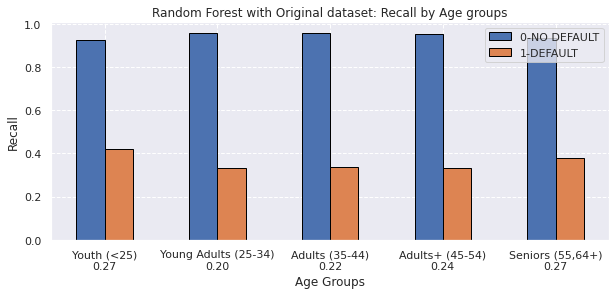

<Figure size 720x288 with 0 Axes>

In [12]:
data0 = class0_R
data1 = class1_R
    
info_plot = { 'label0': '0-NO DEFAULT',
    'label1': '1-DEFAULT',
    'xlabel': "Age Groups",
    'ylabel': "Recall",
    'title' : "Random Forest with Original dataset: Recall by Age groups",
    'txt_label': [("%s\n%.02f" % ( group_name_AGE[i], class1_percent[i])) for i in range(len(group_name_AGE))],
    'path_to_save': 'random_forest_original_age_group.png',    
}
    
plot_bar_by_feature_group(data0, data1, info_plot)

### Random Forest: SMOTE data

In [15]:
forest_pipeline = make_pipeline(SMOTENC([1,2,3,5,6,7,8,9,10],random_state=42), forest)

y_pred_forest_smote = cross_val_predict(forest_pipeline, X=features, y=label, cv=skf5, method='predict', n_jobs=5)

metrics.f1_score(label, y_pred_forest_smote, average='macro') 

0.6897396419481328

### Feature AGE Analyses 

In [16]:
data['y_pred_forest_smote'] = y_pred_forest_smote
df = data

class1_R = []
class0_R = []
class1_P = []
class0_P = []
class1_percent = []

for name in group_name_AGE:     
    data_by_age = df[df['AGE_GROUP']  == name]    
    y_true = data_by_age['DEFAULT']
    y_pred = data_by_age['y_pred_forest_smote']
    
    f1macro = metrics.f1_score(y_true, y_pred, average='macro')          
    print(name, f1macro, data_by_age.shape[0])
    
    N = data_by_age.shape[0]    
    M = confusion_matrix(y_true, y_pred)
    
    # Recall
    mr = M.astype(float)
    mr[0] = mr[0]/np.sum(mr[0])
    mr[1] = mr[1]/np.sum(mr[1])
    #print(mr, '\n')    
    class1_R.append(mr[1][1])
    class0_R.append(mr[0][0])
    
    # Precision
    mp = M.astype(float)    
    mp[:,0] = mp[:,0]/np.sum(mp[:,0])
    mp[:,1] = mp[:,1]/np.sum(mp[:,1])
    #print(mp, '\n')    
    class1_P.append(mp[1][1])
    class0_P.append(mp[0][0])
        
    # Percentage group size for class 1
    class1_percent.append((M[1][0] + M[1][1])/  np.sum(M[:,:]))
 

Youth (<25) 0.701396808112275 2685
Young Adults (25-34) 0.682040706081136 13011
Adults (35-44) 0.6899022181871717 9018
Adults+ (45-54) 0.6905895236705712 4233
Seniors (55,64+) 0.7083469721767593 1053


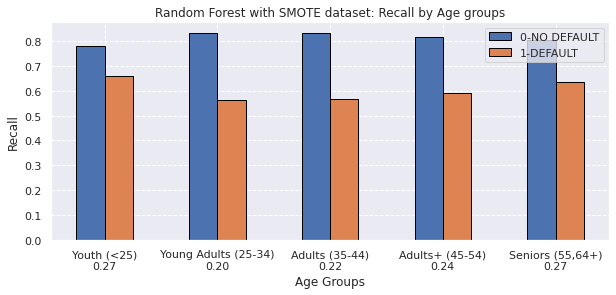

<Figure size 720x288 with 0 Axes>

In [17]:
data0 = class0_R
data1 = class1_R
    
info_plot = { 'label0': '0-NO DEFAULT',
    'label1': '1-DEFAULT',
    'xlabel': "Age Groups",
    'ylabel': "Recall",
    'title' : "Random Forest with SMOTE dataset: Recall by Age groups",
    'txt_label': [("%s\n%.02f" % ( group_name_AGE[i], class1_percent[i])) for i in range(len(group_name_AGE))],
    'path_to_save': 'random_forest_smote_age_group.png',    
}
    
plot_bar_by_feature_group(data0, data1, info_plot)

## Checking the amount of TP, TN, FP and FN among agr groups

In [18]:
TP_df =  data[(y_pred_forest_smote == label) & (label==1)]
TN_df =  data[(y_pred_forest_smote == label) & (label==0)]
FP_df =  data[(y_pred_forest_smote == 1) & (label==0)]
FN_df =  data[(y_pred_forest_smote == 0) & (label==1)]
print(TP_df.shape[0],FP_df.shape[0], FP_df.shape[0],FN_df.shape[0])

3867 4081 4081 2769


In [19]:
TP_df['AGE_GROUP'].value_counts()

Young Adults (25-34)    1487
Adults (35-44)          1121
Adults+ (45-54)          599
Youth (<25)              481
Seniors (55,64+)         179
Name: AGE_GROUP, dtype: int64

In [20]:
TN_df['AGE_GROUP'].value_counts()

Young Adults (25-34)    8636
Adults (35-44)          5879
Adults+ (45-54)         2624
Youth (<25)             1523
Seniors (55,64+)         621
Name: AGE_GROUP, dtype: int64

In [21]:
FP_df['AGE_GROUP'].value_counts()

Young Adults (25-34)    1734
Adults (35-44)          1168
Adults+ (45-54)          596
Youth (<25)              432
Seniors (55,64+)         151
Name: AGE_GROUP, dtype: int64

In [22]:
FN_df['AGE_GROUP'].value_counts()

Young Adults (25-34)    1154
Adults (35-44)           850
Adults+ (45-54)          414
Youth (<25)              249
Seniors (55,64+)         102
Name: AGE_GROUP, dtype: int64

### Feature PAY_0 Analyses 

In [24]:

feature_name = 'PAY_0'
new_feature_name = 'PAY_0_GROUP'

#group_range_PAY_0 = [ (bins[i],bins[i+1]) for i in range(len(bins)-1)]
#group_name_PAY_0 = (["(%.03f,%.02f)" % (bins[i],bins[i+1]) for i in range(len(bins)-1)])
#data = add_group_feature(data, feature_name, new_feature_name, group_name_AGE, group_range_AGE)

group_name_PAY_0 =  [ str(value) for value in np.sort(data['PAY_0'].unique())]


df = data

class1_R = []
class0_R = []
class1_P = []
class0_P = []
class1_percent = []

for value in np.sort(data['PAY_0'].unique()):     
    data_by_PAY_0 = df[df['PAY_0']  == value]
    
    y_true = data_by_PAY_0['DEFAULT']
    y_pred = data_by_PAY_0['y_pred_forest_smote']
    
    f1macro = metrics.f1_score(y_true, y_pred, average='macro')          
    print('VALUE=%d F1macro=%0.2f AmountSample=%d'% (value, f1macro, data_by_PAY_0.shape[0]))
    
    N = data_by_PAY_0.shape[0]    
    M = confusion_matrix(y_true, y_pred)
    
    #print(M)
    # Recall
    mr = M.astype(float)
    mr[0] = mr[0]/np.sum(mr[0])
    mr[1] = mr[1]/np.sum(mr[1])
    #print(mr, '\n')    
    class1_R.append(mr[1][1])
    class0_R.append(mr[0][0])
    
    # Precision
    mp = M.astype(float)    
    mp[:,0] = mp[:,0]/np.sum(mp[:,0]) if np.sum(mp[:,0])!=0 else 1
    mp[:,1] = mp[:,1]/np.sum(mp[:,1]) if np.sum(mp[:,0])!=0 else 1
    #print(mp, '\n')    
    class1_P.append(mp[1][1])
    class0_P.append(mp[0][0])
        
    # Percentage group size for class 1
    class1_percent.append((M[1][0] + M[1][1])/  np.sum(M[:,:]))
 

VALUE=-2 F1macro=0.55 AmountSample=2759
VALUE=-1 F1macro=0.59 AmountSample=5686
VALUE=0 F1macro=0.55 AmountSample=14737
VALUE=1 F1macro=0.52 AmountSample=3688
VALUE=2 F1macro=0.44 AmountSample=2667
VALUE=3 F1macro=0.43 AmountSample=322
VALUE=4 F1macro=0.41 AmountSample=76
VALUE=5 F1macro=0.33 AmountSample=26
VALUE=6 F1macro=0.35 AmountSample=11
VALUE=7 F1macro=0.44 AmountSample=9
VALUE=8 F1macro=0.37 AmountSample=19


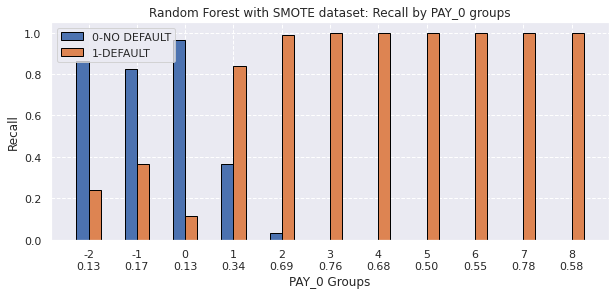

<Figure size 720x288 with 0 Axes>

In [26]:
data0 = class0_R
data1 = class1_R

info_plot = { 'label0': '0-NO DEFAULT',
    'label1': '1-DEFAULT',
    'xlabel': "PAY_0 Groups",
    'ylabel': "Recall",
    'title' : "Random Forest with SMOTE dataset: Recall by PAY_0 groups",
    'txt_label': [("%s\n%.02f" % ( group_name_PAY_0[i], class1_percent[i])) for i in range(len(group_name_PAY_0))],
    'path_to_save': 'random_forest_smote_pay0_group.png',    
} 
plot_bar_by_feature_group(data0, data1, info_plot)